In [2]:
import numpy as np
import pandas as pd

# RNN

In [259]:
class LinearLayer:
    def __init__(self,input_dim,out_dim,bias=True):
        self.weight=np.random.rand(input_dim,out_dim)
        if bias:
            self.bias=np.random.rand(out_dim)
        else:
            self.bias=0

    def __call__(self,x):
        out=np.matmul(x,self.weight)+self.bias
        return out

class RNN:
    def __init__(self,input_dim,hidden_dim,out_dim):
        self.hidden_dim=hidden_dim
        self.input_dim=input_dim
        self.out_dim=out_dim

        self.out_layer=LinearLayer(hidden_dim,out_dim)
        self.wx=LinearLayer(input_dim,hidden_dim,bias=False)
        self.wh=LinearLayer(hidden_dim,hidden_dim,bias=False)
        self.bias=np.random.rand(hidden_dim)
        self.g=np.tanh
        
        self.gradients=None
        self.cache=None
        
        self.parameters={'dh_dwh':self.wh.weight,
                         'dh_dwx':self.wx.weight,
                         'dh_db':self.bias,
                         'dw2':self.out_layer.weight,
                         'db2':self.out_layer.bias}
        
    def __call__(self,x):
        hidden=np.zeros(self.hidden_dim)
        h=np.zeros((x.shape[0],self.hidden_dim))
        
        for i,xi in enumerate(x):
            h[i]=self.g(self.wx(xi)+self.wh(hidden)+self.bias)
            hidden=h[i]
        
        
        out=self.out_layer(h)
        self.cache={'hidden':h,'output':out}
        
        return out
    
    def grads(self,x,h_t,h_tp1):
        mat=np.identity(self.hidden_dim)
        np.fill_diagonal(mat,1-h_tp1*h_tp1)
        
        dh_dwh=np.tensordot(mat,h_t,axes=0) #[hid_dim,hid_dim,hid_dim]
        dh_dwx=np.tensordot(mat,x,axes=0) #[hid_dim,hid_dim,input_dim]
        dh_dh=np.dot(mat,self.wh.weight) #[hid_dim,hid_dim]
        dh_db=mat #[hid_dim,hid_dim]
        
        return dh_dh, {'dh_dwh':dh_dwh,'dh_dwx':dh_dwx,'dh_db':dh_db}

# Loss function

In [287]:
class MSE_Loss:
    def __init__(self,model):
        self.model=model
        
    def __call__(self,x,y):
        y_pred=self.model(x)
        loss=y-y_pred
        loss=loss*loss
        
        return loss.mean()
    
    def backward(self,x,y):
        
        L=x.shape[0]
        h=self.model.cache['hidden']
        out=self.model.cache['output']
        z=(out-y)/L # (y_pred-y)/N
        
        w2=self.model.out_layer.weight.T #[out_dim,hidden_dim]
        grads_cache={'dh_dwh':[],'dh_dwx':[],'dh_db':[]}
        grads_total={'dh_dwh': 0,'dh_dwx': 0,'dh_db': 0}
        
        hidden=np.zeros(self.model.hidden_dim)
        for i,xi in enumerate(x):
            
            dh_dh,grads=self.model.grads(xi,hidden,h[i])
            hidden=h[i]
            
            for var,grad in grads.items():
                wt=np.dot(w2,grad)
                grads_cache[var].append(grad)
                grads_total[var]+=np.tensordot(z[i],wt,axes=([0],[0]))
                
            if i>0:
                for var in grads_cache.keys():
                    temp=[]
                    for j, dh in enumerate(grads_cache[var]):
                        wt=np.tensordot(dh_dh,dh,axes=([1],[0]))
                        temp.append(wt)
                        wt2=np.tensordot(w2,wt,axes=([1],[0]))
                        a=np.tensordot(z[i],wt2,axes=([0],[0]))
                        grads_total[var]+=a
                        
                    grads_cache[var]=temp[:]
        
        grads_total['dw2']=np.tensordot(z,h,axes=([0],[0])).T
        grads_total['db2']=z.sum(0)
        grads_total['dh_dwh']=grads_total['dh_dwh'].T
        grads_total['dh_dwx']=grads_total['dh_dwx'].T
        
        self.model.gradients=grads_total

# Optimizer

In [288]:
class Optimizer:
    def __init__(self,model,lr):
        self.model=model
        self.lr=lr
    
    def step(self):
        grads=self.model.gradients
        
        for var in self.model.parameters:
            self.model.parameters[var]-=self.lr*grads[var]

In [260]:
rnn=RNN(input_dim=2,hidden_dim=3,out_dim=2)

In [261]:
loss=MSE_Loss(rnn)

In [262]:
y=np.random.normal(0,1,(10,2))

In [263]:
loss(x,y)

3.167766031958348

In [264]:
loss.backward(x,y)

In [318]:
def train(seqs,targets,model, loss,optimizer,epochs):
    
    for epoch in range(epochs):
        total_loss=0
        for seq,target in tqdm(zip(seqs,targets),total=len(seqs)):
            ypred=model(seq)
            total_loss+=loss(ypred,target)
            loss.backward(seq,target)
            optimizer.step()
        
        print('epoch: ',epoch,' Loss: ',total_loss)

# Data preparation and Training

In [242]:
seq_len=10

In [415]:
seqs=[]
targets=[]
xs=[]
for n in range(100):
    ts=np.linspace(n*np.pi,(n+1)*np.pi,seq_len+1)
    xs.append(ts[:-1])
    data=np.sin(ts)
    # add noise
    data=data.reshape(-1,1)
    noise=np.random.normal(0,0.008,data.shape)
    data+=noise
    
    seqs.append(data[:-1])
    targets.append(data[1:].reshape(-1,1))

In [416]:
rnn=RNN(1,5,1)
loss=MSE_Loss(rnn)
opt=Optimizer(rnn,lr=0.1)

In [434]:
train(seqs,targets,rnn,loss,opt,3)

 11%|█         | 11/100 [00:00<00:00, 107.22it/s]

epoch:  0  Loss:  2.139028680233493


  7%|▋         | 7/100 [00:00<00:01, 66.89it/s]

epoch:  1  Loss:  2.1096636238535953


100%|██████████| 100/100 [00:01<00:00, 75.00it/s]

epoch:  2  Loss:  2.081229158924499


In [293]:
import matplotlib.pyplot as plt 

In [322]:
import seaborn as sns
sns.set()

In [418]:
xs=np.concatenate(xs)

In [435]:
data=np.array([])
for seq in seqs:
    data=np.concatenate([data,seq[:,0]])

y_pred=np.array([])
for seq in seqs:
    y=rnn(seq)
    y_pred=np.concatenate([y_pred,y[:,0]])

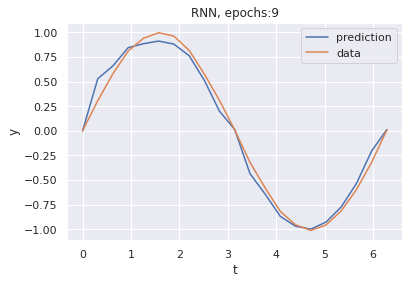

In [436]:
plt.plot(xs[:21],y_pred[:21],label='prediction')
plt.plot(xs[:21],data[:21],label='data')
plt.legend()
plt.title('RNN, epochs:{}'.format(9))
plt.xlabel('t')
plt.ylabel('y')
#plt.savefig('RNN_9epochs.png')
plt.show()